In [1]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /home/divyansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

import wandb
YOUR_API_KEY = '1f727919afa59f54d78e3232b21fcf774d2fb392'
os.environ["WANDB_API_KEY"] = YOUR_API_KEY
wandb_logger = WandbLogger(project='wikohow-t5')

wandb: Currently logged in as: divyansh_1011 (build_neo). Use `wandb login --relogin` to force relogin


In [3]:
from nlp import list_datasets
datasets_list = list_datasets()
print(', '.join(dataset.id for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, americas_nli, ami, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, beans, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, biosses, blbooks, blbooksgenre, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bnl_newspapers, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, casino, catalonia_independence, cats_vs_dogs, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt

In [4]:
    from nlp import load_dataset
dataset = load_dataset('wikihow', 'all', data_dir='data/')


In [5]:
print(dataset.keys())

dict_keys(['train', 'validation', 'test'])


In [6]:
print("Size of training data", dataset['train'].shape)

Size of training data (157252, 3)


In [7]:
print("size of validation data", dataset['validation'].shape)

size of validation data (5599, 3)


In [8]:
print("size of the test dataset", dataset['test'].shape
     )

size of the test dataset (5577, 3)


In [9]:
print(dataset['train'][0].keys())

dict_keys(['headline', 'text', 'title'])


In [10]:
print("Example text", dataset['train'][2]['text'])

Example text It is possible to become a VFX artist without a college degree, but the path is often easier with one. VFX artists usually major in fine arts, computer graphics, or animation. Choose a college with a reputation for strength in these areas and a reputation for good job placement for graduates. The availability of internships is another factor to consider.Out of the jobs advertised for VFX artists, a majority at any given time specify a bachelor’s degree as a minimum requirement for applicants.;
, Some studios offer short-term programs for people who want to learn more about VFX artistry without pursuing a college degree. Enrolling in these programs can be expensive as financial aid isn’t always offered, but they usually have the most cutting edge technology for you to learn from., Although you may create some hand sketches, the majority of your work will be completed on the computer using the most up-to-date programs. Stay informed about the newest software advances by foll

In [11]:
print("example of summary:" + dataset['train'][0]['headline'])

example of summary:Keep related supplies in the same area.
Make an effort to clean a dedicated workspace after every session.
Place loose supplies in large, clearly visible containers.
Use clotheslines and clips to hang sketches, photos, and reference material.
Use every inch of the room for storage, especially vertical space.
Use chalkboard paint to make space for drafting ideas right on the walls.
Purchase a label maker to make your organization strategy semi-permanent.
Make a habit of throwing out old, excess, or useless stuff each month.


In [12]:
print(" Example of Title: ", dataset['train'][0]['title'])

 Example of Title:  How to Be an Organized Artist1


In [13]:
#Estimating the average length of the text and the summary over a tiny dataset 

tiny_dataset = dataset['train'].select(list(range(0,100)))
text_len = []
summary_len = []

In [14]:
text_len

[]

In [15]:
for i in range(len(tiny_dataset)):
    example = tiny_dataset[i]
    text_example = example['text']
    text_example = text_example.replace('\n','')
    text_words = text_example.split()
    text_len.append(len(text_words))
    summary_example = example['headline']
    summary_example = summary_example.replace('\n', '')
    summary_words = summary_example.split()
    summary_len.append(len(summary_words))

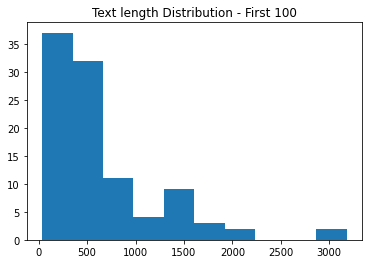

In [16]:
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.hist(text_len)
plt.title('Text length Distribution - First 100')
plt.show()

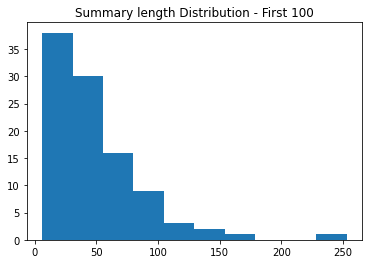

In [17]:
plt.hist(summary_len)
plt.title('Summary length Distribution - First 100')
plt.show()

In [18]:
#Average length of the summary and text 
print(sum(text_len)/len(text_len))
print(sum(summary_len)/len(summary_len))


662.69
48.8


In [19]:
#Define the model 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [20]:
set_seed(42)

In [21]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams,*args):
        super(T5FineTuner, self).__init__()
        self.hparams.update(vars(hparams))
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.rouge_metric = load_metric('rouge') 
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        
    
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
            
    def freeze_embeds(self):
        """Freeze token embeddings and positional embeddings for bart, just token embeddings for t5."""
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)
    
    def lmap(self, f, x):
        """list(map(f, x))"""
        return list(map(f, x))
    

    def is_logger(self):
        return self.trainer.global_rank <= 0
    
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None,labels=None
  ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
    )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=150, 
            num_beams=2,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
#         rouge: Dict = self.calc_generative_metrics(preds, target)
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        self.rouge_metric.add_batch(preds, target)
        
#         rouge_results = self.rouge_metric.compute() 
#         rouge_dict = self.parse_score(rouge_results)
#         base_metrics.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        return base_metrics
    

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
  
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL'],
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    

    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [22]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

In [23]:
class wikihow(Dataset):
    def __init__(self, tokenizer, type_path, num_samples, input_length, output_length, print_text=False):         
        self.dataset =  load_dataset('wikihow', 'all', data_dir='data/', split=type_path)
        if num_samples:
            self.dataset = self.dataset.select(list(range(0, num_samples)))
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
  
    def __len__(self):
        return self.dataset.shape[0]
    
    def clean_text(self, text):
        text = text.replace('Example of text:', '')
        text = text.replace('Example of Summary:', '')
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        if self.print_text:
            print("Input Text: ", self.clean_text(example_batch['text']))
#         input_ = self.clean_text(example_batch['text']) + " </s>"
#         target_ = self.clean_text(example_batch['headline']) + " </s>"
        
        input_ = self.clean_text(example_batch['text'])
        target_ = self.clean_text(example_batch['headline'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
        

In [24]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = wikihow(tokenizer, 'validation', None, 512, 150, True)
len(dataset)

5599

In [25]:
data = dataset[50]
print()
print("Shape of Tokenized Text: ", data['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data['source_ids']))
print("====================================")
print("Sanity check - Decode Summary: ", tokenizer.decode(data['target_ids']))

Input Text:  You can use a smaller size (3/4 inch is used here), but it won't be as strong.;, Be sure that the feet are headed in the same direction and the shape is as squared as you can get it. It is very easy to get turned around. You want it to shrink somewhat (like it would naturally) before you affix it to the frame.If you are going to be making a quilted bed, do what you need to, to get it ready. The soft part of this setup is a small velour blanket folded into quarters., You could use rivets, snaps, hooks, even Velcro. Keep in mind that you are going to have to clean it periodically.A particularly easy method is to sew the material around the sides, but you won't be able to glue the legs to the corner ends, completely.

Shape of Tokenized Text:  torch.Size([512])

Sanity check - Decode Text:  You can use a smaller size (3/4 inch is used here), but it won't be as strong.;, Be sure that the feet are headed in the same direction and the shape is as squared as you can get it. It is

In [26]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_input_length=512,
    max_output_length=150,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=4,
    eval_batch_size=4,
    num_train_epochs=2,
    gradient_accumulation_steps=8,
    n_gpu=1,
    resume_from_checkpoint=None, 
    val_check_interval = 0.05, 
    n_val=1000,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    #opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [27]:
args_dict.update({'output_dir': 't5_wikihow', 'num_train_epochs':2,
                 'train_batch_size': 4, 'eval_batch_size': 4})
args = argparse.Namespace(**args_dict)
#print(args_dict)
print(args)

Namespace(adam_epsilon=1e-08, early_stop_callback=False, eval_batch_size=4, fp_16=False, freeze_embeds=False, freeze_encoder=False, gradient_accumulation_steps=8, learning_rate=0.0003, max_grad_norm=1.0, max_input_length=512, max_output_length=150, model_name_or_path='t5-small', n_gpu=1, n_test=-1, n_train=-1, n_val=1000, num_train_epochs=2, output_dir='t5_wikihow', resume_from_checkpoint=None, seed=42, tokenizer_name_or_path='t5-small', train_batch_size=4, val_check_interval=0.05, warmup_steps=0, weight_decay=0.0)


In [28]:
## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=args.output_dir, monitor="val_loss", mode="min", save_top_k=3
)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    #pus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    #arly_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
   #amp_level=args.opt_level,
    resume_from_checkpoint=args.resume_from_checkpoint,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    callbacks=[LoggingCallback()],
)

In [29]:
def get_dataset(tokenizer, type_path, num_samples, args):
      return wikihow(tokenizer=tokenizer, type_path=type_path, num_samples=num_samples,  input_length=args.max_input_length, 
                        output_length=args.max_output_length)

In [30]:
model = T5FineTuner(args)

In [31]:
trainer = pl.Trainer(**train_params)

/home/divyansh/Divyansh/projects/TextSummarizer/packages/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fbbbe203220>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fbbbe203220>)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
    
trainer.fit(model)

/home/divyansh/Divyansh/projects/TextSummarizer/packages/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  rank_zero_warn(
/home/divyansh/Divyansh/projects/TextSummarizer/packages/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]